In [50]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph,distance_plots
import pandas as pd
from scipy.spatial import distance_matrix
import json
import dataframe_image as dfi

In [51]:
name="GC-orginal_resize"+".json"
with open(name, 'r') as f: 
  meta = json.load(f)
#needed from base file
epoch_conversions=[431, 431, 431, 431, 431, 431]  #specify by orginal file
#Gc Clustersh277-ch4
#[431, 1208, 2727, 3812, 3455, 1873]
#resize
#topology
#[561, 561, 561, 561,561,561]
#GC
#[431, 431, 431, 431, 431, 431]
#general number for 5 features (these manually need to be changed)
byte=268  
resolution=500
epochs=100
g_comp=6
#getting data files
processed=get_processed_data()
var=.9
#this code should not matter just put in for future development
interest=["H2@100 bar/243K (wt%)"]
interest2 = ['H2@100 bar/77K (wt%)']
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=False)
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=False)
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],interest2[0],'topology']]=data[['MOF ID',interest[0],interest2[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],interest2[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

In [52]:
%%capture
#surpressing output because it is depreciated, plots are generated later with a df for clarity, this only serves to get df outputs now
# below processes raw data for use in tables from json
Cluster_colors=[
"#009E73",
"#E69F00",
"#56B4E9",
"#F0E442",
"#D55E00",
"#CC79A7"]
dic,dic2,std=create_dictionaries(g_comp)
dic=unpack_dic(dic,meta)
#removes unused keys if less than 6
keys=[]
for i in dic:
    if not dic[i]:
        keys.append(i)
for i in keys:
    dic.pop(i)
std=create_std_matrix(dic,std)
dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2,adjust=100,save=True)
keys=[]
for i in dic2:
    if not dic2[i]:
        keys.append(i)
for i in keys:
    dic2.pop(i)
# Further processing
master=Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std,epochs,save=False)
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"Cluster"]]=abridge[['Pc1', 'Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
m1=make_distance_graph(dic,distances,Cluster_colors,"PC1 and PC2",save=False)
hold=pd.DataFrame()
hold[['Pc1',"Cluster"]]=abridge[['Pc1',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
m2=make_distance_graph(dic,distances,Cluster_colors,"PC1",save=False)
hold=pd.DataFrame()
hold[['Pc2',"Cluster"]]=abridge[['Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
m3=make_distance_graph(dic,distances,Cluster_colors,"PC2",save=False)

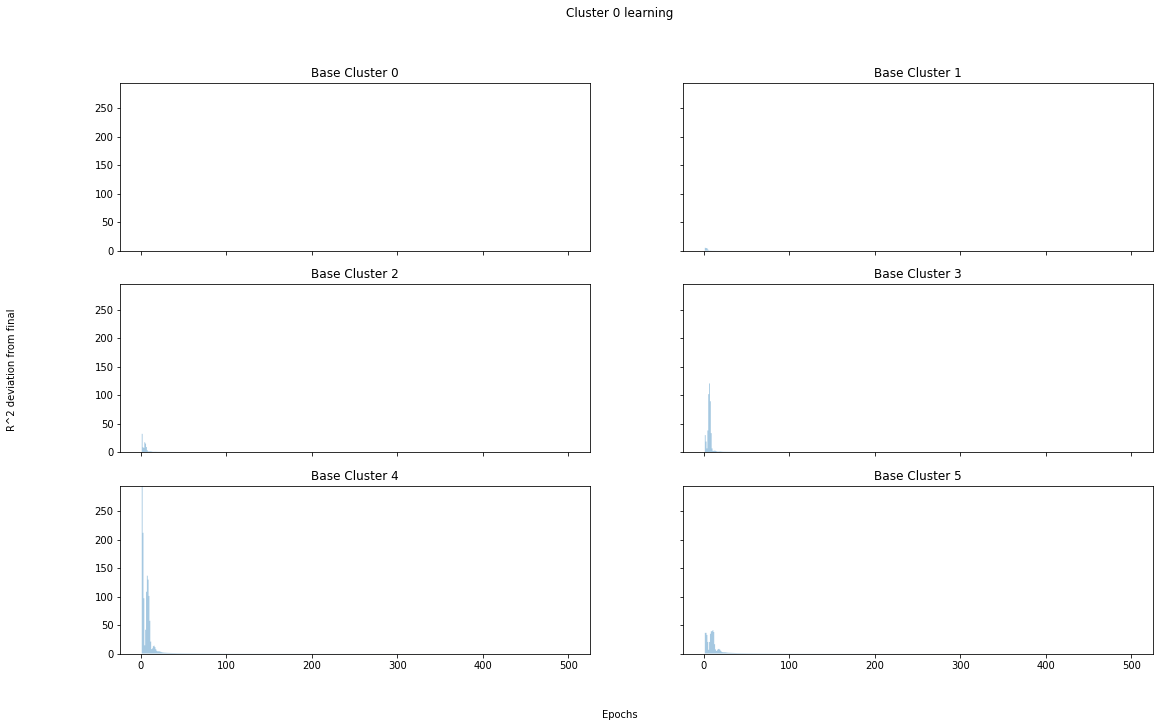

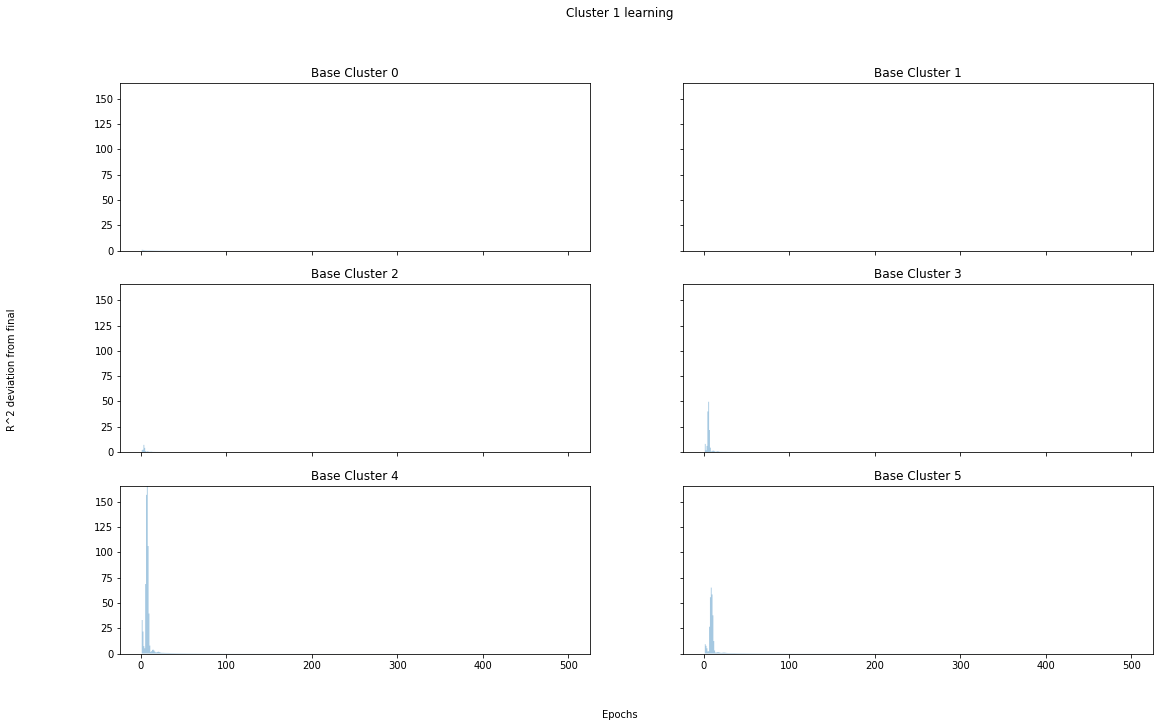

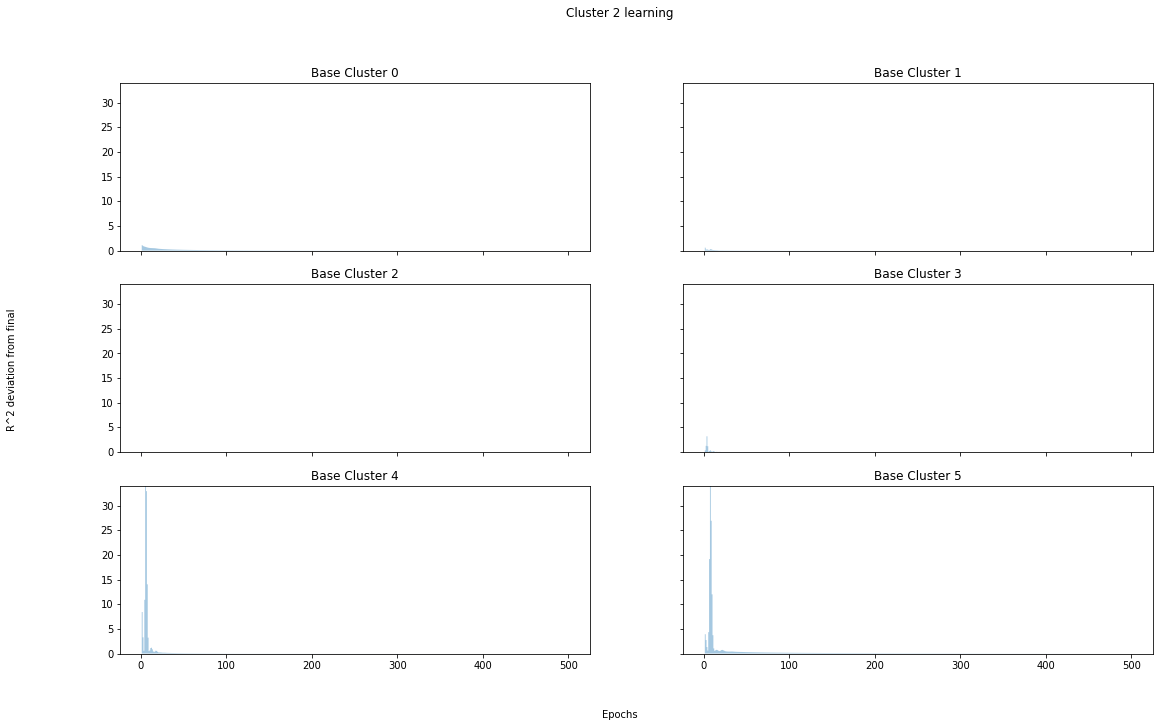

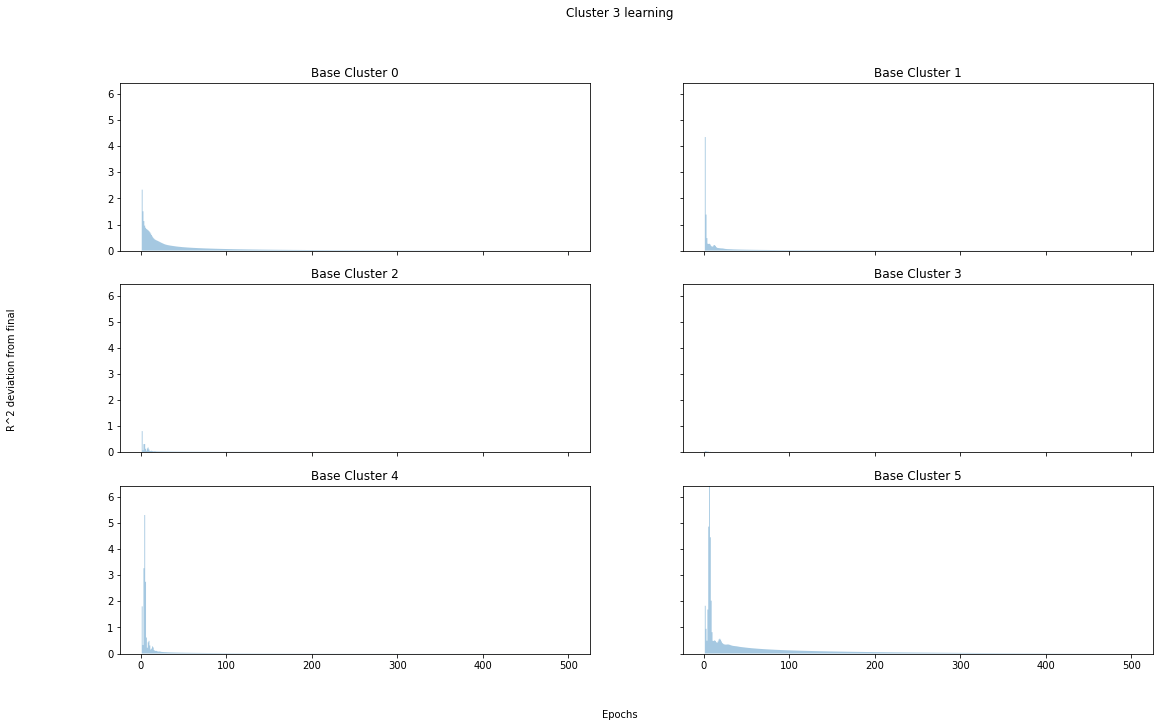

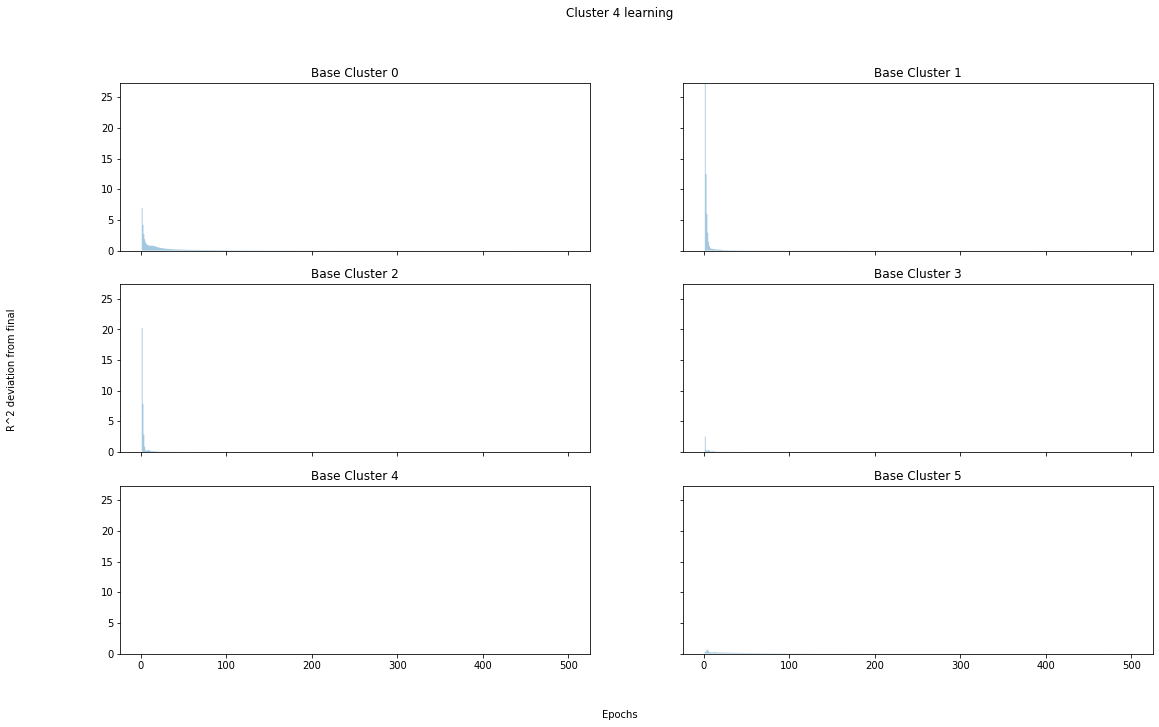

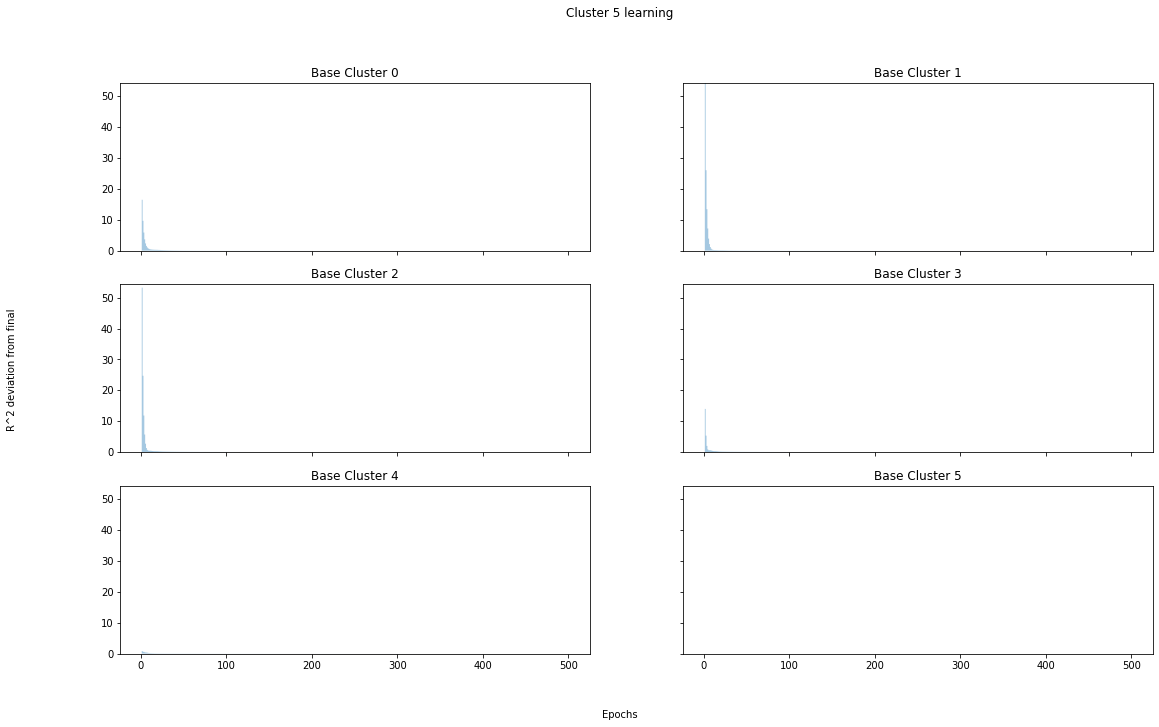

In [54]:
#Generates figures for base learning curve
import numpy as np
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[int(g)][count]=np.array(base[int(g)][count])+np.array(z)
anaylsis(base,adjust=100)

In [55]:
# Code below is used to generate the dfs needed for figures later
main_df=pd.DataFrame()
sets=["set1","set2","set3"]
for count,i in enumerate(zip(m1,m2,m3)):
    a,b,c=i
    df=pd.DataFrame(m1[a]).T
    #display(df)
    df=df.reset_index(drop=False)
    df.columns=["Cluster","Distance",'Mean','Std']
    df["PC1 distance"]=pd.DataFrame(m2[b]).T[0]
    df["PC2 distance"]=pd.DataFrame(m3[c]).T[0]
    df[["Avg Worst (R^2 deviation)","Worst Std"]]=pd.DataFrame(master[(count,'set1')]).T
    df[["Avg Info. (MB to reach 95% Final)","Info Std"]]=pd.DataFrame(master[(count,'set2')]).T
    df[["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"]]=pd.DataFrame(master[(count,'set3')]).T
    df["Base Cluster"]=count
    main_df=pd.concat([main_df,df],axis=0)
colors={}
for count,i in enumerate(Cluster_colors):
    colors[count]=i
real_df=main_df.sort_values(by="Distance").__deepcopy__()
real_df=real_df.replace("Over",0)
real_df.loc[:, real_df.columns != "Mean"]=real_df.loc[:, real_df.columns != "mean"].apply(abs)
real_df[["Std","Worst Std","Info Std","Learn Std"]]=real_df[["Std","Worst Std","Info Std","Learn Std"]]/10
display(real_df)
real_df["color"]=real_df["Cluster"].map(colors)

groupped=real_df.groupby(["Base Cluster","Cluster"]).sum().replace(0,"N/A")
#rescale by root 100 for the monte carlo
display(real_df)
dfi.export(groupped, 'groupped.png')

,Cluster,Distance,Mean,Std,PC1 distance,PC2 distance,Avg Worst (R^2 deviation),Worst Std,Avg Info. (MB to reach 95% Final),Info Std,Avg Learn (Net R^2 to reach 95% Final),Learn Std,Base Cluster
0,0,0.000000,0.938018,0.003175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,0.000000,0.997258,0.000070,0.000000,0.000000,0.027107,0.001077,0.000000,0.000000,0.000000,0.000000,4
3,3,0.000000,0.989987,0.000242,0.000000,0.000000,0.043128,0.001934,0.000000,0.000000,0.000000,0.000000,3
2,2,0.000000,0.968466,0.000850,0.000000,0.000000,0.049869,0.003321,0.000000,0.000000,0.000000,0.000000,2
1,1,0.000000,0.959499,0.001401,0.000000,0.000000,0.054891,0.003873,0.138424,0.000000,0.000000,0.000000,1
5,5,0.000000,0.999059,0.000042,0.000000,0.000000,0.006962,0.000325,0.000000,0.000000,0.000000,0.000000,5
3,3,1.484350,0.989604,0.000304,1.420950,0.429181,2.536667,0.052307,0.390505,0.018333,0.574556,0.026426,4
4,4,1.484350,0.980366,0.000413,1.420950,0.429181,5.313607,0.030142,0.780084,0.036666,3.248480,0.127093,3
2,2,1.490794,0.979571,0.000459,1.441202,0.381317,0.804979,0.028111,0.321756,0.009167,0.296049,0.016131,3
3,3,1.490794,0.943677,0.001406,1.441202,0.381317,3.202161,0.012204,0.298839,0.009167,1.237043,0.061610,2


,Cluster,Distance,Mean,Std,PC1 distance,PC2 distance,Avg Worst (R^2 deviation),Worst Std,Avg Info. (MB to reach 95% Final),Info Std,Avg Learn (Net R^2 to reach 95% Final),Learn Std,Base Cluster,color
0,0,0.000000,0.938018,0.003175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,#009E73
4,4,0.000000,0.997258,0.000070,0.000000,0.000000,0.027107,0.001077,0.000000,0.000000,0.000000,0.000000,4,#D55E00
3,3,0.000000,0.989987,0.000242,0.000000,0.000000,0.043128,0.001934,0.000000,0.000000,0.000000,0.000000,3,#F0E442
2,2,0.000000,0.968466,0.000850,0.000000,0.000000,0.049869,0.003321,0.000000,0.000000,0.000000,0.000000,2,#56B4E9
1,1,0.000000,0.959499,0.001401,0.000000,0.000000,0.054891,0.003873,0.138424,0.000000,0.000000,0.000000,1,#E69F00
5,5,0.000000,0.999059,0.000042,0.000000,0.000000,0.006962,0.000325,0.000000,0.000000,0.000000,0.000000,5,#CC79A7
3,3,1.484350,0.989604,0.000304,1.420950,0.429181,2.536667,0.052307,0.390505,0.018333,0.574556,0.026426,4,#F0E442
4,4,1.484350,0.980366,0.000413,1.420950,0.429181,5.313607,0.030142,0.780084,0.036666,3.248480,0.127093,3,#D55E00
2,2,1.490794,0.979571,0.000459,1.441202,0.381317,0.804979,0.028111,0.321756,0.009167,0.296049,0.016131,3,#56B4E9
3,3,1.490794,0.943677,0.001406,1.441202,0.381317,3.202161,0.012204,0.298839,0.009167,1.237043,0.061610,2,#F0E442


objc[61782]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59114550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x113683568). One of the two will be used. Which one is undefined.
[0110/120303.717240:INFO:headless_shell.cc(623)] Written to file /var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/tmpqbgx9u1y/temp.png.
objc[61801]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59114550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x113f03568). One of the two will be used. Which one is undefined.
[0110/120305.702990:INFO:headless_shell.cc

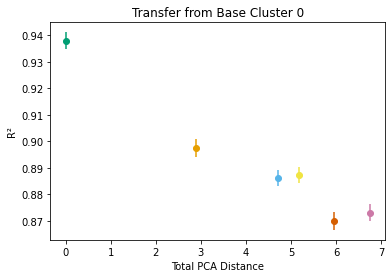

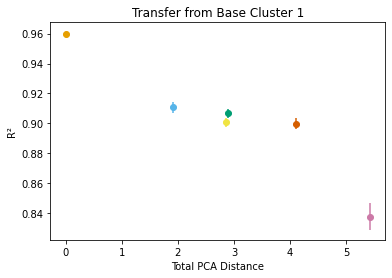

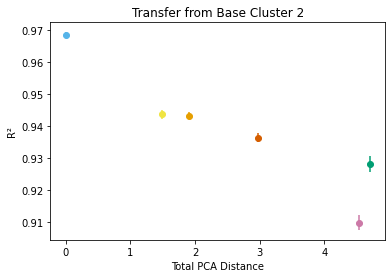

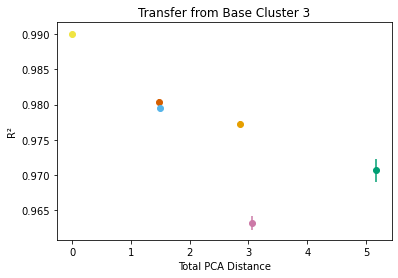

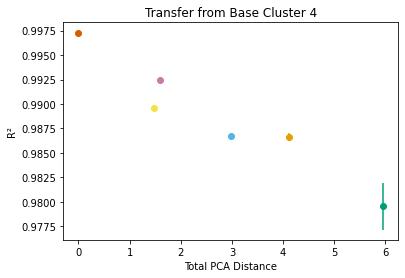

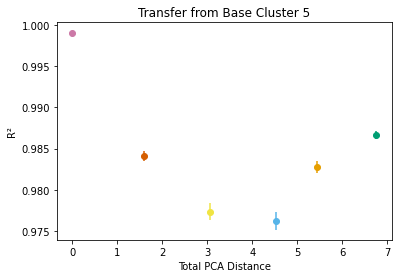

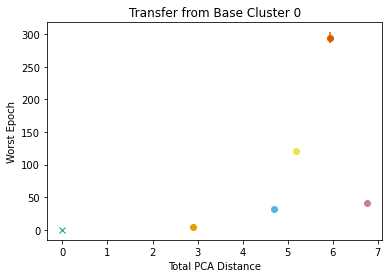

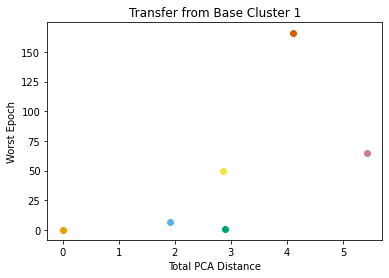

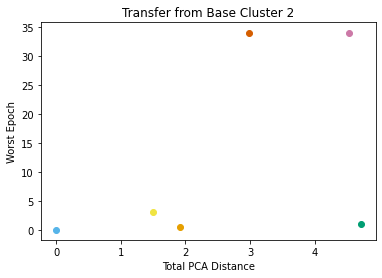

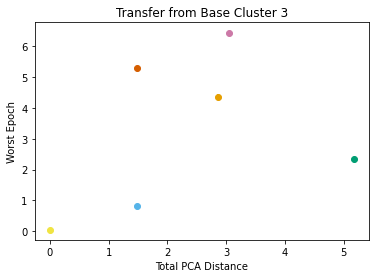

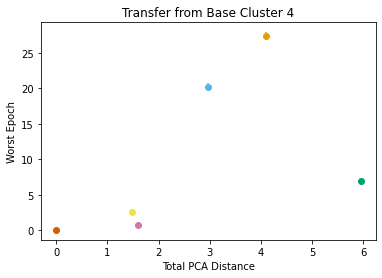

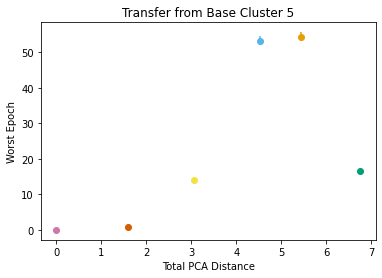

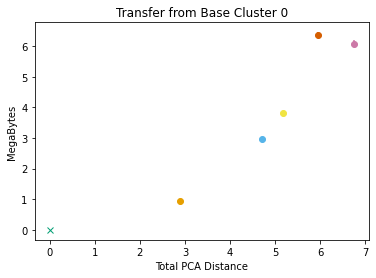

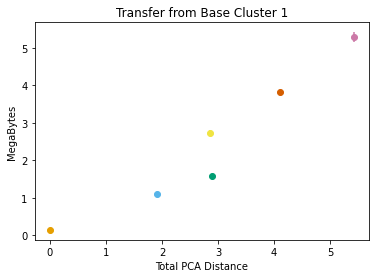

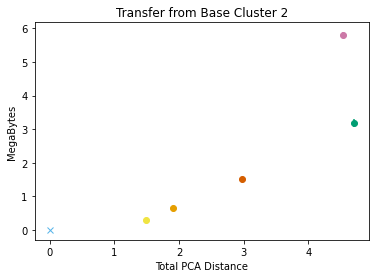

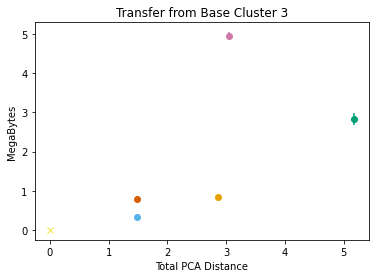

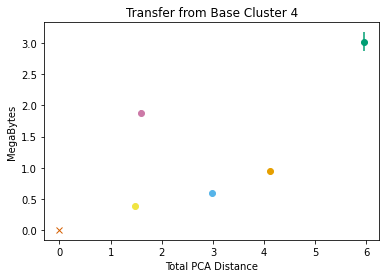

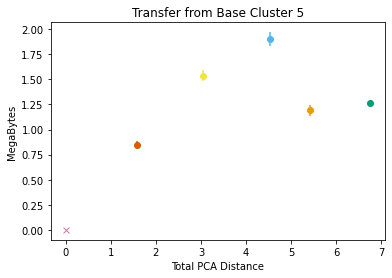

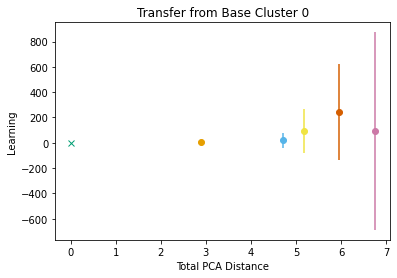

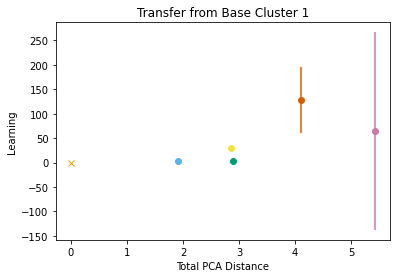

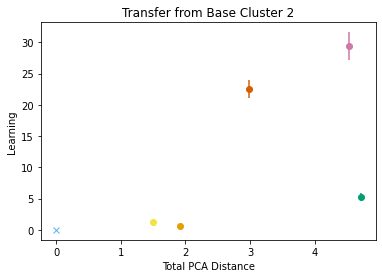

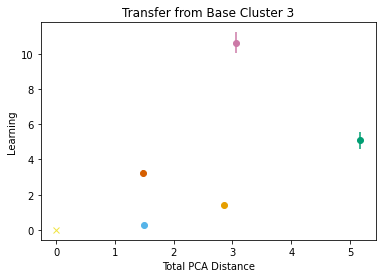

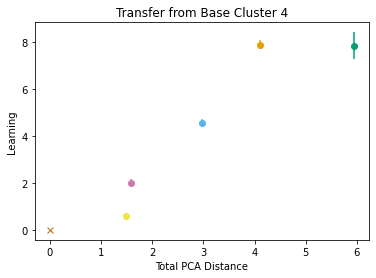

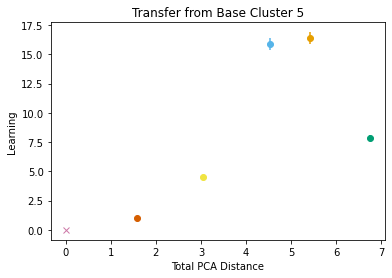

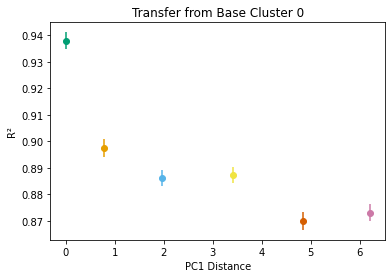

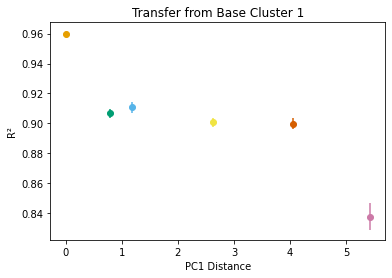

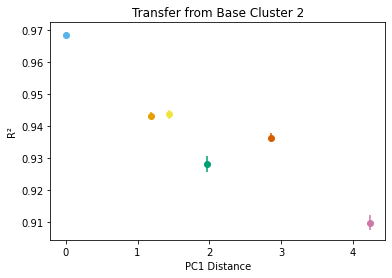

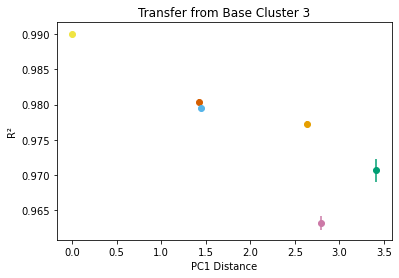

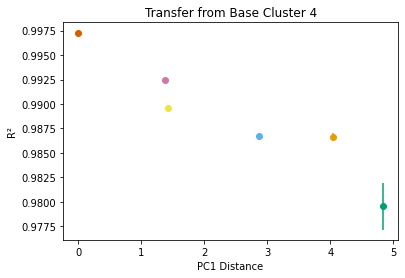

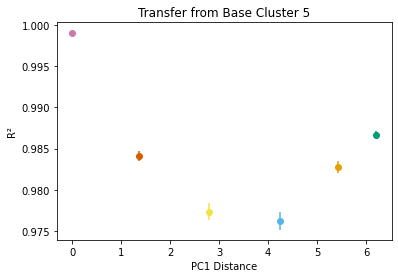

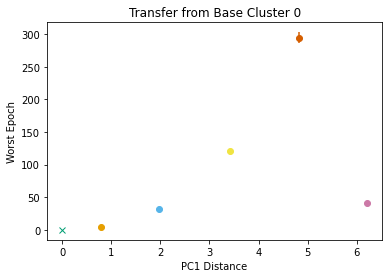

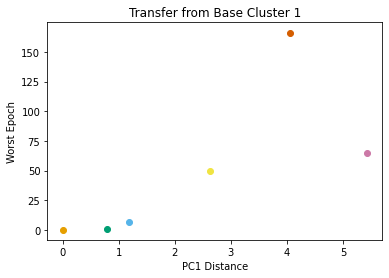

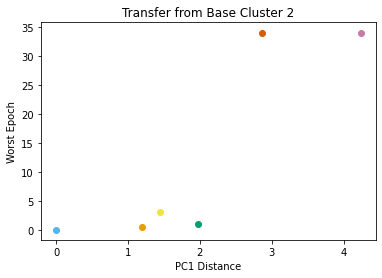

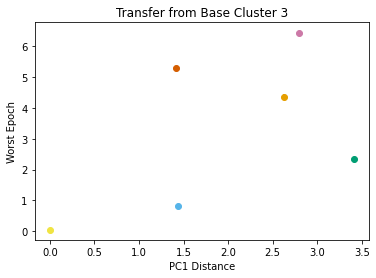

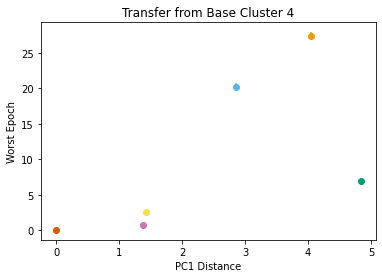

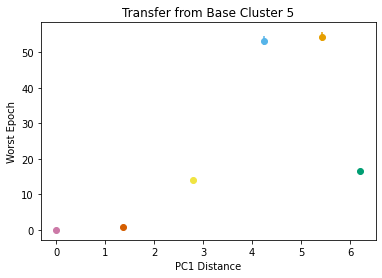

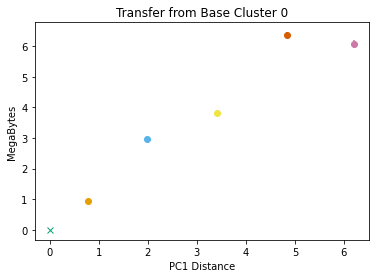

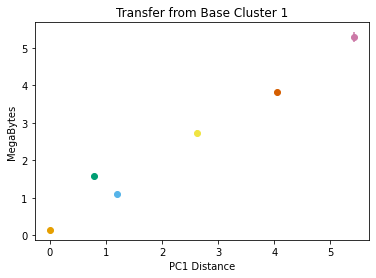

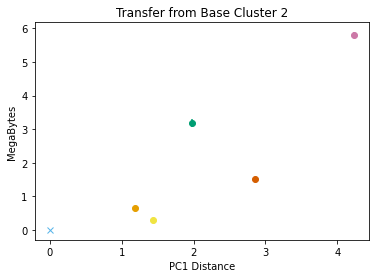

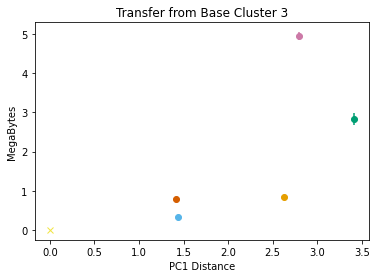

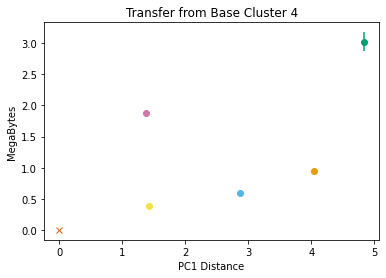

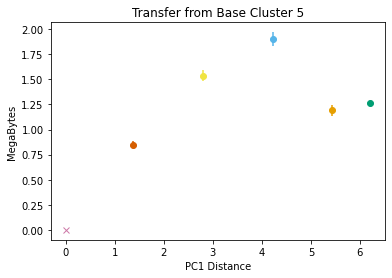

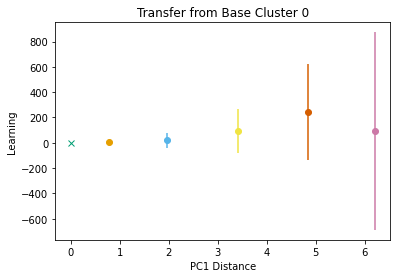

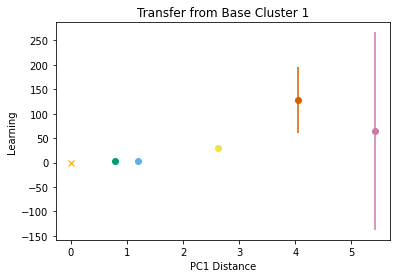

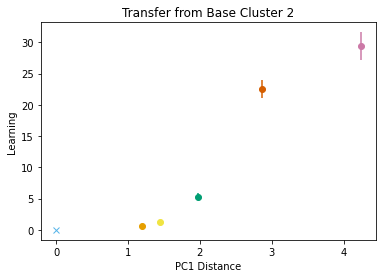

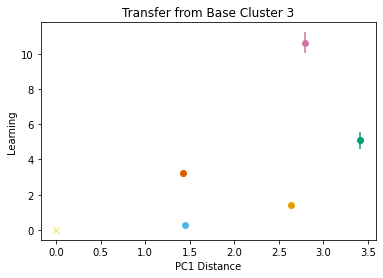

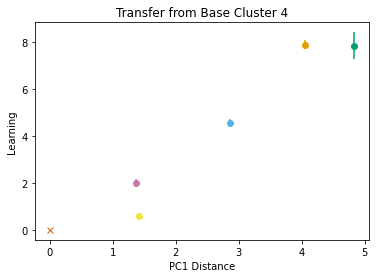

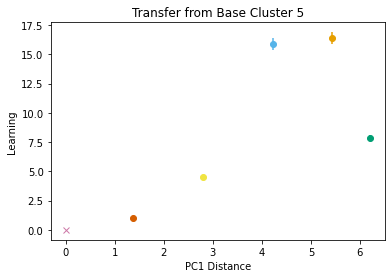

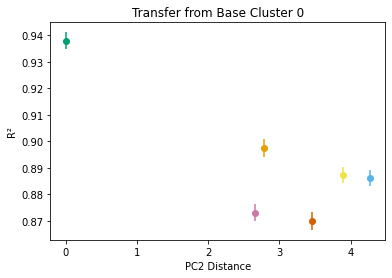

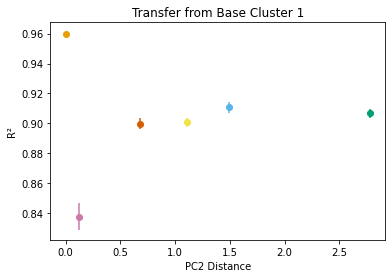

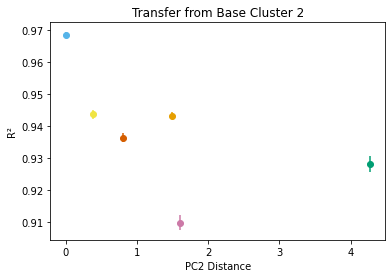

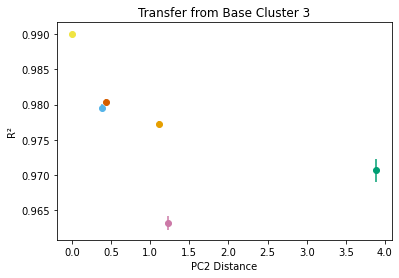

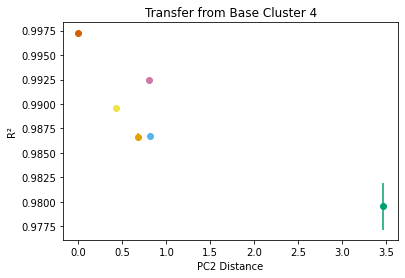

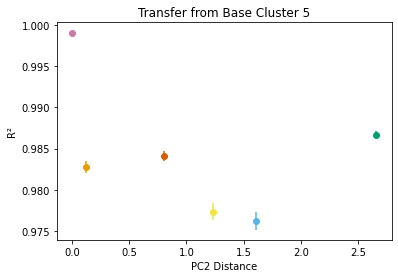

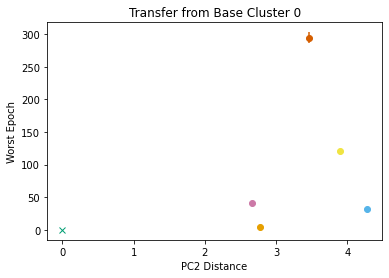

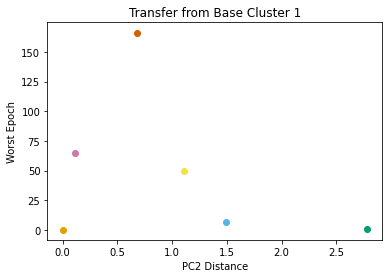

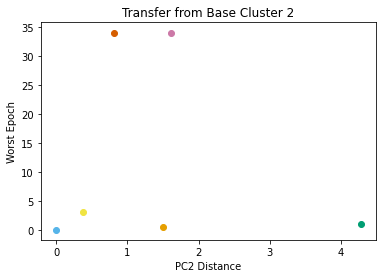

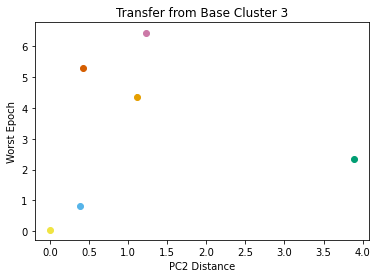

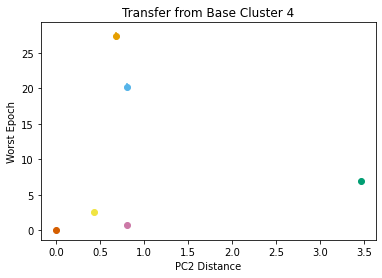

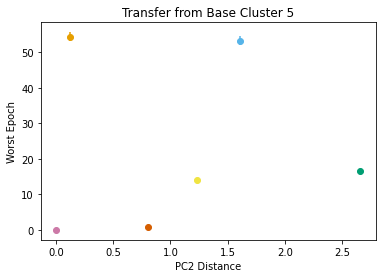

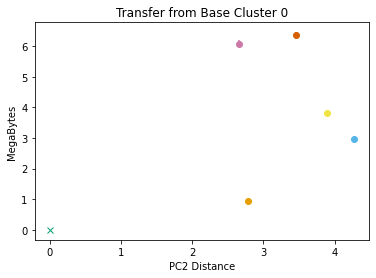

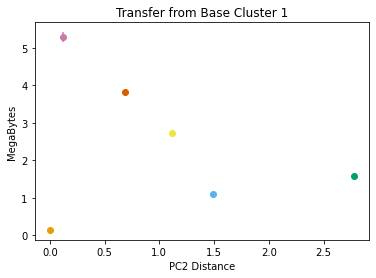

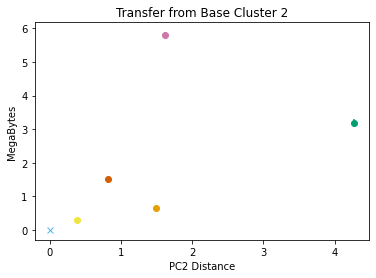

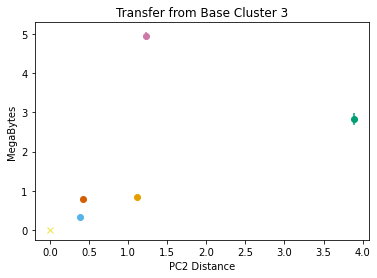

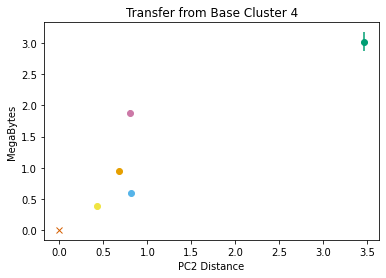

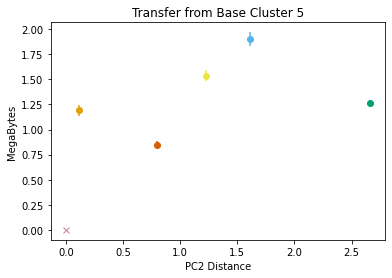

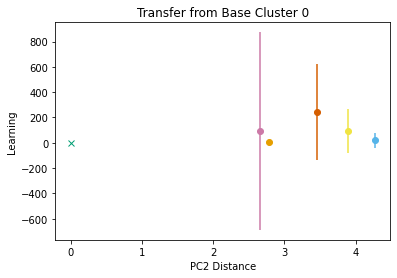

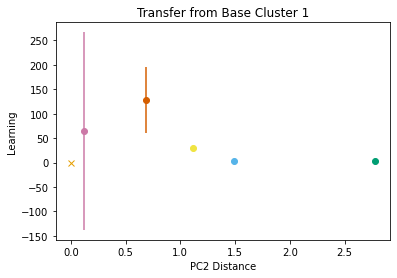

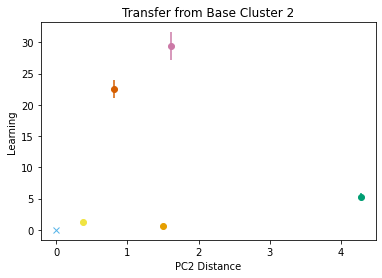

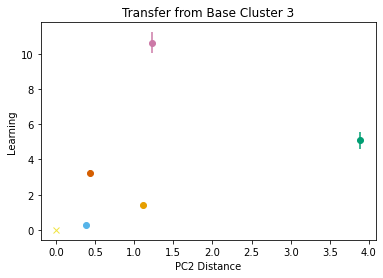

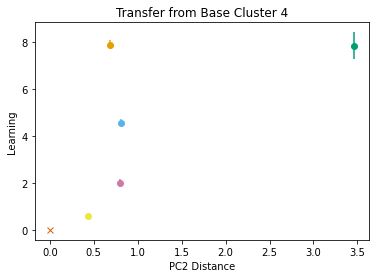

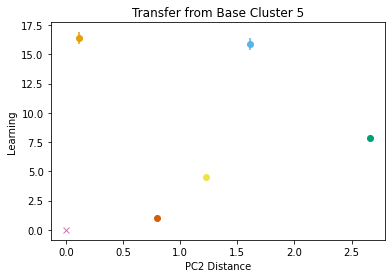

In [56]:
# Actually creates the figures from the DF
graphs={
0: ["Mean","Std"],
1: ["Avg Worst (R^2 deviation)","Worst Std"],
2: ["Avg Info. (MB to reach 95% Final)","Info Std"],
3: ["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"],
}
x="Distance"
names=[u"R\u00b2","Worst Epoch","MegaBytes","Learning"]

def make_plot(df,x,y,error,base,xtitle,ytitle):
    for i in df.iterrows():
        i=i[1]
        if i[y] == 0:
            marker="x"
        else:
            marker='o'
        g=i["Cluster"]
        plt.errorbar(i[x],i[y],yerr=i[error],color=i["color"],marker=marker,label=f"Cluster {g}")
    #plt.legend()
    plt.title(f"Transfer from Base Cluster {base}")
    plt.ylabel(ytitle) 
    plt.xlabel(xtitle)

for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"Total PCA Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()
    
x="PC1 distance"
for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"PC1 Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()

x="PC2 distance"
for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"PC2 Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()

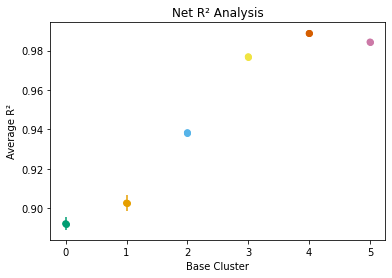

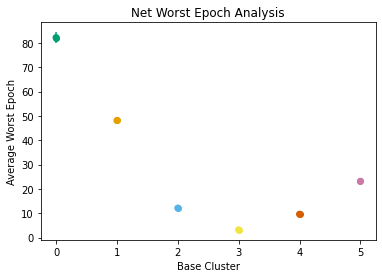

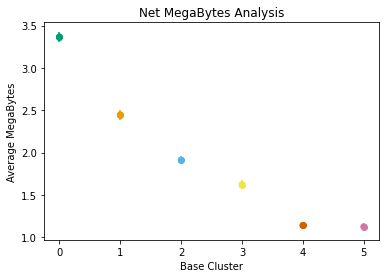

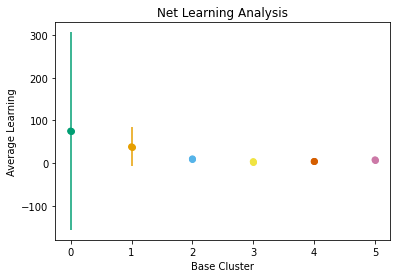

In [57]:
# Creates figures for base values (averaging out above data frames)
test=real_df.groupby("Base Cluster").mean()
test["Base Cluster"]=np.array(test.index)
test["Color"]=Cluster_colors
names=[u"R\u00b2","Worst Epoch","MegaBytes","Learning"]
for count,i in enumerate(graphs):
    a,b=graphs[i]
    #test.plot(kind="scatter",x="Base Cluster",y=a,yerr=b,ylabel=a,title=f"{a} vs Base Cluster",c=Cluster_colors)
    #plt.scatter(x=test["Base Cluster"],y=test[a],c=test["Color"])
    plt.scatter(x=test["Base Cluster"],y=test[a],c=test["Color"])
    for i in np.array(test.index):
        plt.errorbar(test["Base Cluster"][i],test[a][i],yerr=test[b][i],color=test["Color"][i],marker="o",label=f"Cluster {i}")
    #plt.errorbar(x=test["Base Cluster"],y=test[a],yerr=Cluster_colors)
    plt.title(f"Net {names[count]} Analysis")
    plt.xlabel("Base Cluster")
    plt.ylabel(f"Average {names[count]}")
    fig_label=f"META_{a}vsBC.png"
    plt.savefig(fig_label,dpi=400)
    plt.show()

In [58]:
# Saves df
test=test.drop("Cluster",axis=1)
dfi.export(test, 'test.png')

objc[61862]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59114550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x113e83568). One of the two will be used. Which one is undefined.
[0110/120331.942300:INFO:headless_shell.cc(623)] Written to file /var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/tmp_zqty8w0/temp.png.
objc[61874]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59114550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x117703568). One of the two will be used. Which one is undefined.
[0110/120333.215377:INFO:headless_shell.cc

In [59]:
#packages pngs
import os
folder=name[:-5]+"new_runs1"
os.mkdir(folder)
path=os.getcwd()
for i in os.listdir(path):
    if (i[-3:]) == "png":
        os.rename(f"{path}/{i}",f"{path}/{folder}/{i}")
    else:
        pass

In [60]:
# Further packaging
path1=f"{path}/{folder}"
meta=path1+"/META"
pc1=path1+"/PC1"
pc2=path1+"/PC2"
rest=path1+"/regular"
tables=path1+"/Tables"
os.mkdir(meta)
os.mkdir(pc1)
os.mkdir(pc2)
os.mkdir(rest)
os.mkdir(tables)
for i in os.listdir(path1):
    if (i[-3:]) != "png":
        pass
    elif "META" in i:
        os.rename(f"{path1}/{i}",f"{meta}/{i}")
    elif "PC1" in i:
        os.rename(f"{path1}/{i}",f"{pc1}/{i}")
    elif "PC2" in i:
        os.rename(f"{path1}/{i}",f"{pc2}/{i}")
    elif "test" in i or "groupped" in i:
        os.rename(f"{path1}/{i}",f"{tables}/{i}")
    else:
        os.rename(f"{path1}/{i}",f"{rest}/{i}")
